# Assignment 2


## Data Management Class for Edge Histograms


In [65]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")


class DataLoader:
    def __init__(self, edge_histograms_dir="./EdgeHistograms"):
        self.edge_histograms_dir = edge_histograms_dir
        self.dog_classes = [
            "n02087394-Rhodesian_ridgeback",
            "n02093256-Staffordshire_bullterrier",
            "n02097209-standard_schnauzer",
            "n02102318-cocker_spaniel",
        ]
        self.dog_labels = [
            "Rhodesian Ridgeback",
            "Staffordshire Bullterrier",
            "Standard Schnauzer",
            "Cocker Spaniel",
        ]
        self.X = []
        self.y = []

    def load_data(self):
        for dog_class in self.dog_classes:
            class_dir = os.path.join(self.edge_histograms_dir, dog_class)
            if not os.path.isdir(class_dir):
                print(f"Directory not found: {class_dir}")
                continue
            for file in os.listdir(class_dir):
                if file.endswith(".npy"):
                    histogram_path = os.path.join(class_dir, file)
                    hist = np.load(histogram_path)
                    self.X.append(hist)
                    self.y.append(dog_class)

        self.X = np.array(self.X)
        self.y = np.array(self.y)

        return self.X, self.y


## Data Preprocessing Class


In [66]:
class DataPreprocessor:
    def __init__(self, test_size=0.2, random_state=42):
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = StandardScaler()

    def split_and_scale(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test


## Model Evaluation Class


In [67]:
class ModelEvaluator:
    def __init__(self, dog_classes, dog_labels):
        self.dog_classes = dog_classes
        self.dog_labels = dog_labels

    def perform_cross_validation(self, model, X, y, cv=5):
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=skf, scoring="accuracy")
        return scores.mean()

    def plot_confusion_matrix(self, y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred, labels=self.dog_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=self.dog_labels,
            yticklabels=self.dog_labels,
        )
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(title)
        plt.show()

    def evaluate_model(self, model, X_train, y_train, X_test, y_test, model_name):
        # Cross-validation
        cv_score = self.perform_cross_validation(model, X_train, y_train)
        print(f"{model_name} Mean CV Accuracy: {cv_score:.4f}")

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Plot confusion matrix
        self.plot_confusion_matrix(y_test, y_pred, f"{model_name} Confusion Matrix")

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")

        print(f"\n{model_name} Test Accuracy: {accuracy:.4f}")
        print(f"{model_name} Test F1-Score: {f1:.4f}")
        print(f"\n{model_name} Classification Report:")
        print(classification_report(y_test, y_pred, target_names=self.dog_classes))

        return accuracy, f1, cv_score


## SVM Model Selection Class


In [68]:
class SVMModelSelector:
    def __init__(self, C_values=[0.1, 1, 10, 100]):
        self.C_values = C_values

    def perform_cv_analysis(self, X_train, y_train):
        validation_errors_standard = []
        training_errors_standard = []
        validation_errors_stratified = []
        training_errors_stratified = []

        # Standard CV
        for C in self.C_values:
            svm = LinearSVC(C=C, max_iter=1000, random_state=42)

            scores = cross_val_score(svm, X_train, y_train, cv=5, scoring="accuracy")
            validation_errors_standard.append(1 - scores.mean())

            svm.fit(X_train, y_train)
            train_pred = svm.predict(X_train)
            training_errors_standard.append(1 - accuracy_score(y_train, train_pred))

        # Stratified CV
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for C in self.C_values:
            svm = LinearSVC(C=C, max_iter=1000, random_state=42)

            scores = cross_val_score(svm, X_train, y_train, cv=skf, scoring="accuracy")
            validation_errors_stratified.append(1 - scores.mean())

            svm.fit(X_train, y_train)
            train_pred = svm.predict(X_train)
            training_errors_stratified.append(1 - accuracy_score(y_train, train_pred))

        return (
            validation_errors_standard,
            training_errors_standard,
            validation_errors_stratified,
            training_errors_stratified,
        )

    def plot_error_curves(self, errors):
        val_std, train_std, val_strat, train_strat = errors
        plt.figure(figsize=(10, 6))
        plt.plot(
            self.C_values,
            np.array(val_std) * 100,
            marker="o",
            label="Validation Error (Standard CV)",
        )
        plt.plot(
            self.C_values,
            np.array(train_std) * 100,
            marker="o",
            label="Training Error (Standard CV)",
        )
        plt.plot(
            self.C_values,
            np.array(val_strat) * 100,
            marker="s",
            label="Validation Error (Stratified CV)",
        )
        plt.plot(
            self.C_values,
            np.array(train_strat) * 100,
            marker="s",
            label="Training Error (Stratified CV)",
        )
        plt.xlabel("C")
        plt.ylabel("Mean Error (%)")
        plt.title("Error Rates vs C for LinearSVC")
        plt.legend()
        plt.grid(True)
        plt.show()


## Main Execution


Total samples: 641
Feature dimension: 36
Classes: ['n02087394-Rhodesian_ridgeback' 'n02093256-Staffordshire_bullterrier'
 'n02097209-standard_schnauzer' 'n02102318-cocker_spaniel']

Training samples: 512
Test samples: 129
DecisionTree Mean CV Accuracy: 0.3030


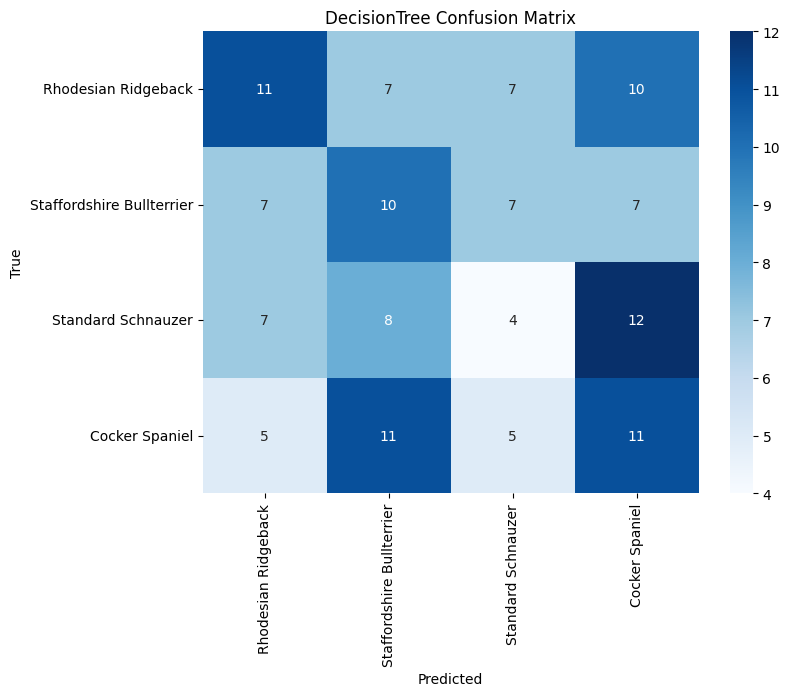


DecisionTree Test Accuracy: 0.2791
DecisionTree Test F1-Score: 0.2750

DecisionTree Classification Report:
                                     precision    recall  f1-score   support

      n02087394-Rhodesian_ridgeback       0.37      0.31      0.34        35
n02093256-Staffordshire_bullterrier       0.28      0.32      0.30        31
       n02097209-standard_schnauzer       0.17      0.13      0.15        31
           n02102318-cocker_spaniel       0.28      0.34      0.31        32

                           accuracy                           0.28       129
                          macro avg       0.27      0.28      0.27       129
                       weighted avg       0.28      0.28      0.27       129

MLPClassifier Mean CV Accuracy: 0.4023


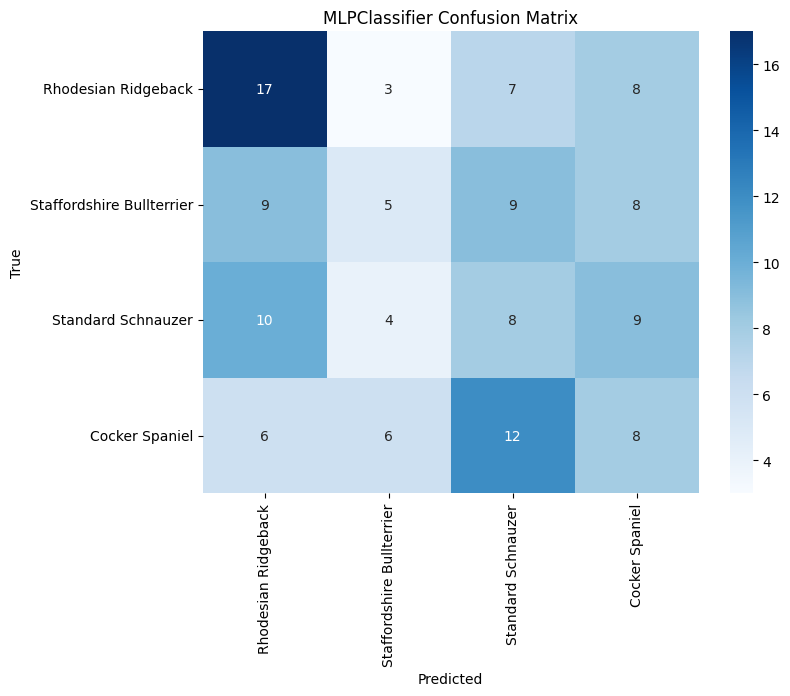


MLPClassifier Test Accuracy: 0.2946
MLPClassifier Test F1-Score: 0.2873

MLPClassifier Classification Report:
                                     precision    recall  f1-score   support

      n02087394-Rhodesian_ridgeback       0.40      0.49      0.44        35
n02093256-Staffordshire_bullterrier       0.28      0.16      0.20        31
       n02097209-standard_schnauzer       0.22      0.26      0.24        31
           n02102318-cocker_spaniel       0.24      0.25      0.25        32

                           accuracy                           0.29       129
                          macro avg       0.29      0.29      0.28       129
                       weighted avg       0.29      0.29      0.29       129

RandomForest Mean CV Accuracy: 0.3615


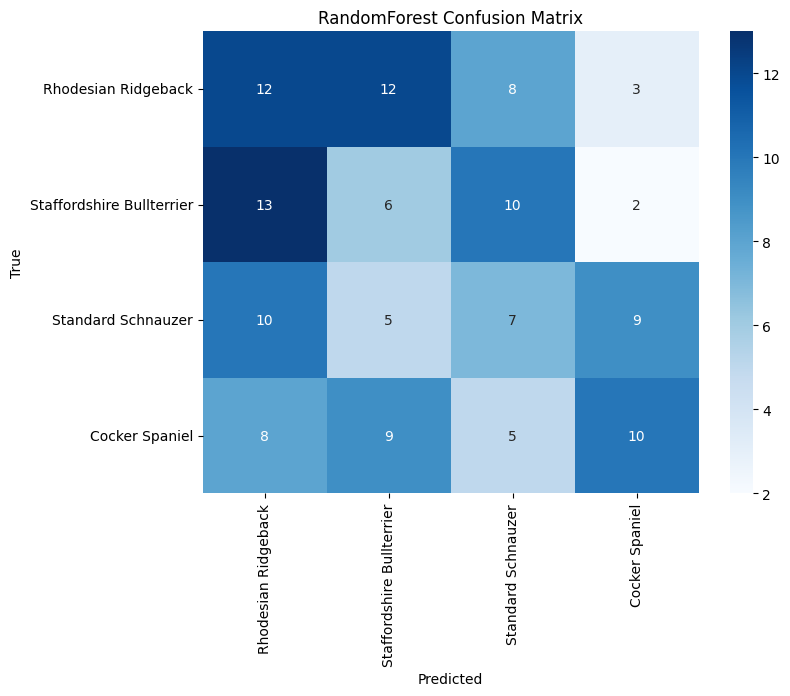


RandomForest Test Accuracy: 0.2713
RandomForest Test F1-Score: 0.2730

RandomForest Classification Report:
                                     precision    recall  f1-score   support

      n02087394-Rhodesian_ridgeback       0.28      0.34      0.31        35
n02093256-Staffordshire_bullterrier       0.19      0.19      0.19        31
       n02097209-standard_schnauzer       0.23      0.23      0.23        31
           n02102318-cocker_spaniel       0.42      0.31      0.36        32

                           accuracy                           0.27       129
                          macro avg       0.28      0.27      0.27       129
                       weighted avg       0.28      0.27      0.27       129



In [69]:
# Initialize and load data
data_loader = DataLoader()
X, y = data_loader.load_data()
print(f"Total samples: {X.shape[0]}")
print(f"Feature dimension: {X.shape[1]}")
print(f"Classes: {np.unique(y)}")

# Preprocess data
preprocessor = DataPreprocessor()
X_train_scaled, X_test_scaled, y_train, y_test = preprocessor.split_and_scale(X, y)
print(f"\nTraining samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")

# Initialize models
models = {
    "DecisionTree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(10, 10, 10), random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
}

# Evaluate models
evaluator = ModelEvaluator(data_loader.dog_classes, data_loader.dog_labels)
results = {}
for name, model in models.items():
    results[name] = evaluator.evaluate_model(
        model, X_train_scaled, y_train, X_test_scaled, y_test, name
    )


## Visual Comparison of Confusion Matrices

Based on visual inspection of the confusion matrices, the **MLPClassifier**
appears to be the best method because:

- It shows darker blue colors along the diagonal, particularly for Rhodesian
  Ridgeback (17 correct predictions)
- The off-diagonal values (misclassifications) are generally lighter in color
- More consistent diagonal pattern indicating better class-wise predictions
- Better balance in predictions across classes compared to other methods

## Best Method Based on Mean Validation Accuracies

Looking at the 5-fold cross-validation accuracies:

- DecisionTree: 0.3030
- MLPClassifier: 0.4023
- RandomForest: 0.3615

The **MLPClassifier** performs best with a mean validation accuracy of 40.23%.

## Best Method Based on Test Set Accuracies

Test accuracies for each method:

- DecisionTree: 0.2791 (27.91%)
- MLPClassifier: 0.2946 (29.46%)
- RandomForest: 0.2713 (27.13%)

The **MLPClassifier** achieves the highest test accuracy at 29.46%.

## Best Method Based on F-measure

F-measure scores on the test set:

- DecisionTree: 0.2750
- MLPClassifier: 0.2873
- RandomForest: 0.2730

The **MLPClassifier** again performs best with an F-measure of 0.2873.

**Overall Conclusion**: The MLPClassifier consistently performs best across all
evaluation metrics (visual confusion matrix analysis, mean validation accuracy,
test accuracy, and F-measure), though it's worth noting that all models show
relatively low performance overall, suggesting this is a challenging
classification task.


## SVM Analysis for Two Classes


Selected Classes Training samples: 261
Selected Classes Test samples: 66


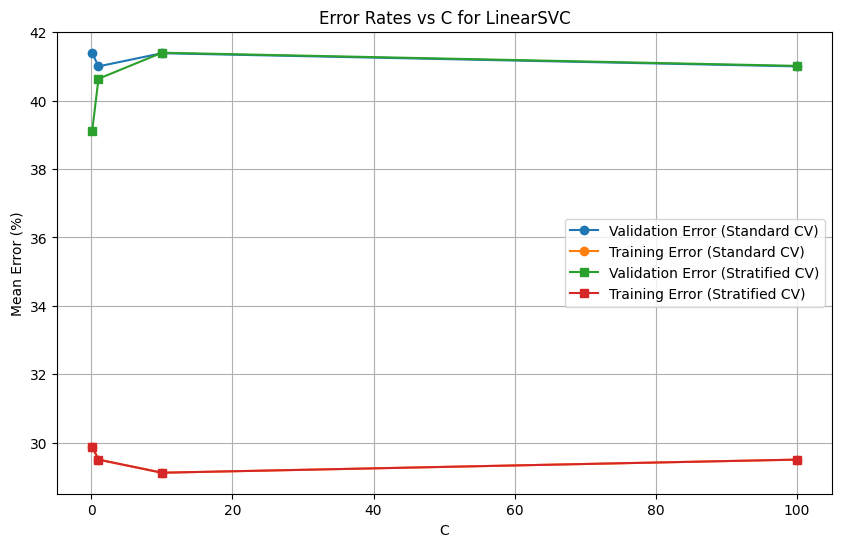


Best C value (lowest stratified validation error): 0.1
Test Error with C=0.1: 34.85%


In [70]:
# Select two classes
selected_classes = data_loader.dog_classes[:2]
mask_train = np.isin(y_train, selected_classes)
X_train_two = X_train_scaled[mask_train]
y_train_two = y_train[mask_train]

mask_test = np.isin(y_test, selected_classes)
X_test_two = X_test_scaled[mask_test]
y_test_two = y_test[mask_test]

print(f"Selected Classes Training samples: {X_train_two.shape[0]}")
print(f"Selected Classes Test samples: {X_test_two.shape[0]}")

# Perform SVM analysis
svm_selector = SVMModelSelector()
error_curves = svm_selector.perform_cv_analysis(X_train_two, y_train_two)
svm_selector.plot_error_curves(error_curves)

# Find best C value and evaluate final model
best_C_index = np.argmin(error_curves[2])  # Using stratified validation errors
best_C = svm_selector.C_values[best_C_index]
print(f"\nBest C value (lowest stratified validation error): {best_C}")

final_svm = LinearSVC(C=best_C, max_iter=1000, random_state=42)
final_svm.fit(X_train_two, y_train_two)
test_pred = final_svm.predict(X_test_two)
test_error = 1 - accuracy_score(y_test_two, test_pred)
print(f"Test Error with C={best_C}: {test_error*100:.2f}%")


## Analysis of Error Curves and C Values

### Lowest Mean Error for Each Curve:

1. **Validation Error (Standard CV)**: Lowest at C = 0.1 (~41%)
2. **Training Error (Standard CV)**: Lowest at C = 0.1 (~29%)
3. **Validation Error (Stratified CV)**: Lowest at C = 0.1 (~39%)
4. **Training Error (Stratified CV)**: Lowest at C = 0.1 (~29%)

### Model Complexity and C Parameter:

1. **Relationship between C and Model Complexity**:

   - The C parameter in SVM controls the trade-off between maximizing the margin
     and minimizing classification errors
   - Lower C values (e.g., 0.1) create larger margins but allow more
     misclassifications
   - Higher C values (e.g., 100) enforce stricter classification, leading to
     smaller margins but fewer training errors
   - Therefore, as C increases, the model complexity increases

2. **Overfitting/Underfitting Analysis**:
   - The gap between training and validation errors remains relatively constant
     across all C values
   - Training errors (~29%) are consistently lower than validation errors
     (~39-41%)
   - The modest and consistent gap between training and validation errors
     suggests neither severe overfitting nor underfitting
   - The fact that best performance is achieved at the lowest C value (0.1)
     suggests the simpler model is more appropriate for this data

## Test Set Performance

Using the best C value (C = 0.1) from stratified cross-validation:

- The test error is 34.85%
- This test error falls between the training (~29%) and validation errors
  (~39%), indicating good generalization
- The model's performance on unseen data aligns well with what we would expect
  based on the cross-validation results

The results suggest that a simpler SVM model (lower C) is more appropriate for
this classification task, and the model achieves consistent performance across
training, validation, and test sets.
